Importing Dataset from Kaggle

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"josealg","key":"7a48c6e737bf20559554911d371a75bc"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle #Create the directory
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd #Print Working Directory
!kaggle datasets download -d muhammadmuzamil5500/gemstones

Convert dataset into a PyTorch dataset

In [2]:
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader, random_split
import torchvision

# Define the desired image size
desired_image_size = (224, 224)

# Transformation for resizing and converting to tensor
transform = torchvision.transforms.Compose([
    Resize(desired_image_size),
    ToTensor(),
])

# Load datasets with resizing and transforming to tensor
train_ds = torchvision.datasets.ImageFolder('/content/drive/MyDrive/FYP_Datasets/train', transform=transform)
test_ds = torchvision.datasets.ImageFolder('/content/drive/MyDrive/FYP_Datasets/test', transform=transform)
valid_ds = torchvision.datasets.ImageFolder('/content/drive/MyDrive/FYP_Datasets/validation', transform=transform)
print("Number of train samples: ", len(train_ds))
print("Number of test samples: ", len(test_ds))
print("Number of validation samples: ", len(valid_ds))

Number of train samples:  3040
Number of test samples:  1500
Number of validation samples:  1500


In [8]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 837.9 kB/s eta 0:00:00


Patch Embedding

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, emb_dim=768, img_size=224):
        super().__init__()
        self.patch_size = 16
        self.n_patches = (img_size ** 2) // (patch_size ** 2)

        # [1] Project Method 1
        self.img2token = Rearrange('b c (h p1) (w p2) -> b (h w) (c p1 p2)', p1=patch_size, p2=patch_size)
        self.linear_projection = nn.Linear(in_channels * (patch_size ** 2), emb_dim)

        # [1] Project Method 2 using Conv2d
        self.projection = nn.Sequential(
            nn.Conv2d(in_channels, emb_dim, patch_size, stride=patch_size),
            Rearrange('b e h w -> b (h w) e')
        )

        # [2] Class Token - from BERT
        self.cls_token = nn.Parameter(torch.randn(1, 1, emb_dim))

        # [3] Position Embedding
        self.position_embedding = nn.Parameter(
            torch.randn(self.n_patches + 1, emb_dim)
        )


    def forward(self, x):
        B = x.shape[0]

        # [1] Tokenize & Linear Projection
        x = self.projection(x) # (B, n, e)

        # [2] Prepend class tokens
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=B)
        x = torch.cat([cls_tokens, x], dim=1) # (B, n+1, e)

        # [3] Position Embedding
        x += self.position_embedding # (B, n+1, e)

        return x

Transformer Encoder

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import reduce, rearrange, repeat

class Encoder(nn.Sequential):
    def __init__(self, depth=12, emb_dim=768, n_heads=8, attn_drop=0.,
                 drop_path=0., expansion=4):
        super().__init__(
            *[EncoderBlock(emb_dim, n_heads, attn_drop, drop_path, expansion)
              for _ in range(depth)]
        )

class EncoderBlock(nn.Module):
    def __init__(self, emb_dim=768, n_heads=8, attn_drop=0.,
                 drop_path=0., expansion=4):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.LayerNorm(emb_dim),
            MultiHeadAttention(emb_dim, n_heads, attn_drop),
            nn.Dropout(drop_path)
        )

        self.block2 = nn.Sequential(
            nn.LayerNorm(emb_dim),
            MLP(emb_dim, expansion, drop_path),
            nn.Dropout(drop_path)
        )

    def forward(self, x):
        skip1 = x
        x = self.block1(x)
        x += skip1

        skip2 = x
        x = self.block2(x)
        x += skip2

        return x

Multi-head Attention

In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_dim=768, n_heads=8, attn_drop=0.):
        super().__init__()
        self.emb_dim = emb_dim
        self.n_heads = n_heads

        self.qkv = nn.Linear(emb_dim, emb_dim * 3)
        self.attn_drop = nn.Dropout(attn_drop)
        self.projection = nn.Linear(emb_dim, emb_dim)

    def forward(self, x):
        qkv = self.qkv(x)
        qkv = rearrange(qkv, "b n (h d qkv) -> qkv b h n d", h=self.n_heads, qkv=3)
        q, k, v = qkv[0], qkv[1], qkv[2] # each (b, h, n, d_h)

        d_h = (self.emb_dim / self.n_heads) ** (0.5)
        attention = torch.einsum('bhqd, bhkd -> bhqk', q, k) # (b, h, n, n)
        attention = F.softmax(attention, dim=-1) / d_h
        attention = self.attn_drop(attention) # (b, h, n, n)

        out = torch.einsum('bhqk, bhvd -> bhqd', attention, v) # (b, h, n, d_h)
        out = rearrange(out, "b h n d_h -> b n (h d_h)") # (b, n, d)
        out = self.projection(out) # (b, n, emb_dim)

        return out

MLP

In [12]:
class MLP(nn.Sequential):
    def __init__(self, emb_dim, expansion=4, drop_path=0.):
        super().__init__(
            nn.Linear(emb_dim, emb_dim * expansion),
            nn.GELU(),
            nn.Dropout(drop_path),
            nn.Linear(emb_dim * expansion, emb_dim)
        )

Classification Head

In [13]:
import torch.nn as nn
from einops.layers.torch import Reduce

class ClassificationHead(nn.Sequential):
    def __init__(self, emb_dim=768, n_classes=10):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_dim),
            nn.Linear(emb_dim, n_classes)
        )

ViT

In [14]:
import torch
import torch.nn as nn

from torchsummary import summary

class ViT(nn.Module):
    def __init__(self,
                 in_channels=3,
                 patch_size=16,
                 n_heads=8,
                 emb_dim=768,
                 attn_drop=0.,
                 drop_path=0.,
                 expansion=4,
                 img_size=224,
                 depth=12,
                 n_classes=10,
                 ):
        super().__init__()

        self.patch_embedding = PatchEmbedding(in_channels, patch_size, emb_dim, img_size)
        self.encoder = Encoder(depth, emb_dim, n_heads, attn_drop, drop_path, expansion)
        self.classification_head = ClassificationHead(emb_dim, n_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder(x)
        x = self.classification_head(x)
        return x

dummy = torch.randn(4, 3, 224, 224)
vit = ViT()
out = vit(dummy)
print("Output shape: {}".format(out.shape))

Output shape: torch.Size([4, 10])


Training

In [3]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

train_dataloader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_ds, batch_size=32, shuffle=True)

Loading the latest checkpoint from: /content/drive/MyDrive/FYP_Datasets/Scratch_CP/model_checkpoint_epoch_15.pth
>>> Epoch 0 train loss: 0.9976514808833599, train accuracy: 0.5856137607505864
>>> Epoch 0 validation loss: 0.8682114393153089, validation accuracy: 0.5293333333333333
>>> Epoch 5 train loss: 0.5098655389621853, train accuracy: 0.7834245504300235
>>> Epoch 5 validation loss: 0.8017752595404362, validation accuracy: 0.6826666666666666
>>> Epoch 10 train loss: 0.5937448434531689, train accuracy: 0.7560594214229867
>>> Epoch 10 validation loss: 0.7455296034508563, validation accuracy: 0.65
>>> Epoch 15 train loss: 0.47750719971954825, train accuracy: 0.8049257232212667
>>> Epoch 15 validation loss: 0.7066036215487946, validation accuracy: 0.684
>>> Epoch 20 train loss: 0.46911645457148554, train accuracy: 0.8033620015637216
>>> Epoch 20 validation loss: 0.7664740554829861, validation accuracy: 0.7126666666666667
>>> Epoch 25 train loss: 0.4940153619274497, train accuracy: 0.790

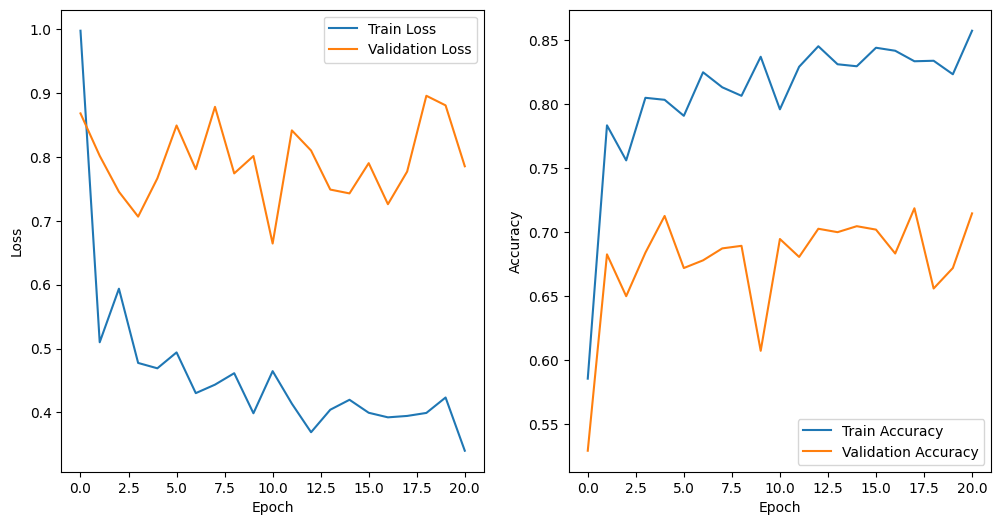

In [12]:
import torch.optim as optim
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

checkpoint_path = '/content/drive/MyDrive/FYP_Datasets/Scratch_CP'
max_epochs = 501
early_stop_patience = 10  # Number of epochs with no improvement after which training will be stopped

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
best_valid_loss = float('inf')
early_stop_counter = 0

# Load the latest checkpoint if available
latest_checkpoint_path = None
for filename in os.listdir(checkpoint_path):
    if filename.startswith("model_checkpoint_epoch_") and filename.endswith(".pth"):
        latest_checkpoint_path = os.path.join(checkpoint_path, filename)

if latest_checkpoint_path:
    print(f"Loading the latest checkpoint from: {latest_checkpoint_path}")
    model.load_state_dict(torch.load(latest_checkpoint_path))

for epoch in range(max_epochs):
    epoch_losses = []
    epoch_predictions = []
    epoch_labels = []
    model.train()

    # Training loop
    for step, (inputs, labels) in enumerate(train_dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

        # Accumulate predictions and labels for accuracy calculation
        _, predicted = torch.max(outputs, 1)
        epoch_predictions.extend(predicted.cpu().numpy())
        epoch_labels.extend(labels.cpu().numpy())

    # Print and save every 5 epochs
    if epoch % 5 == 0:
        # Save the model
        torch.save(model.state_dict(), f'{checkpoint_path}/model_checkpoint_epoch_{epoch}.pth')

        train_loss = np.mean(epoch_losses)
        train_accuracy = accuracy_score(epoch_labels, epoch_predictions)
        print(f">>> Epoch {epoch} train loss: {train_loss}, train accuracy: {train_accuracy}")
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop
        model.eval()
        epoch_losses = []
        epoch_predictions = []
        epoch_labels = []
        for step, (inputs, labels) in enumerate(valid_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_losses.append(loss.item())

            # Accumulate predictions and labels for accuracy calculation
            _, predicted = torch.max(outputs, 1)
            epoch_predictions.extend(predicted.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())

        valid_loss = np.mean(epoch_losses)
        valid_accuracy = accuracy_score(epoch_labels, epoch_predictions)
        print(f">>> Epoch {epoch} validation loss: {valid_loss}, validation accuracy: {valid_accuracy}")
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        # Early stopping check
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= early_stop_patience:
                print(f"Stopping early as validation loss did not improve for {early_stop_patience} epochs.")
                break

# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [15]:
import torch
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ViT().to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/FYP_Datasets/Scratch_CP/model_checkpoint_epoch_100.pth'))

<All keys matched successfully>

Test Accuracy: 0.7867
Test Precision: 0.7874
Test Recall: 0.7867
Test F1 Score: 0.7822
Average Test Loss: 0.5351


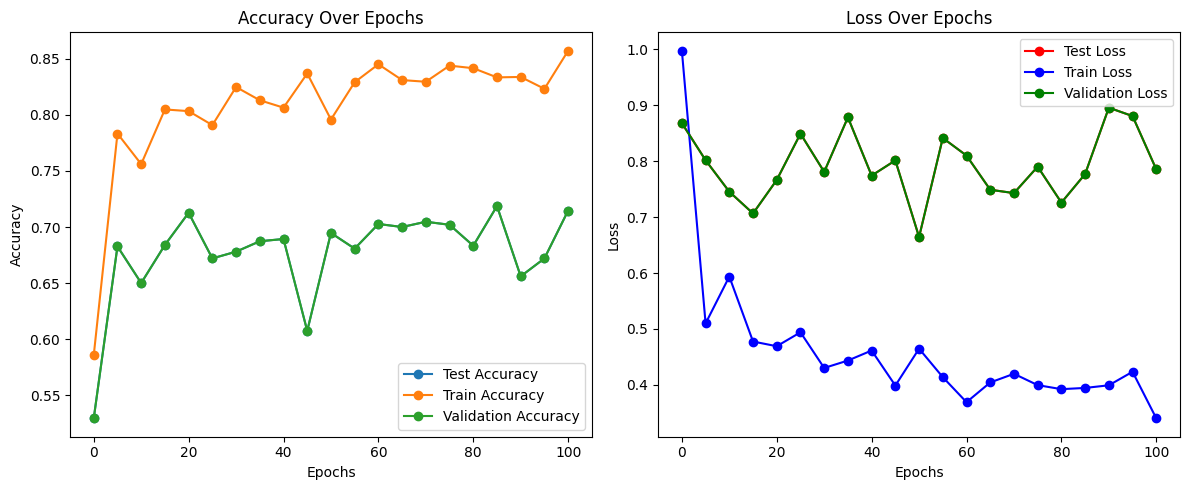

Sample Prediction 1:
Predicted Class: 1
Actual Class: 1


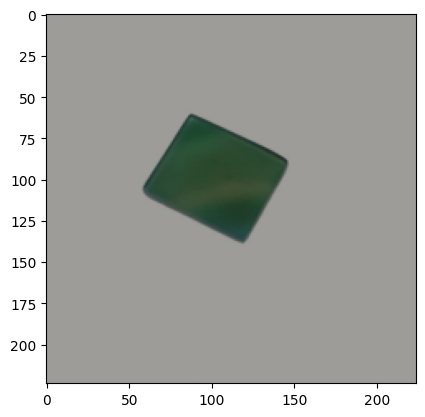


Sample Prediction 2:
Predicted Class: 1
Actual Class: 1


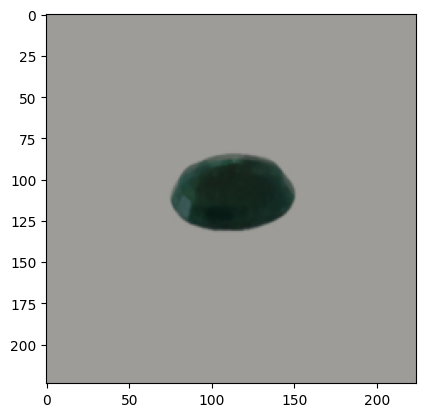


Sample Prediction 3:
Predicted Class: 2
Actual Class: 2


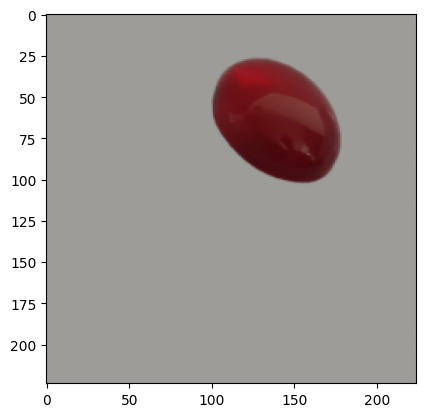


Sample Prediction 4:
Predicted Class: 2
Actual Class: 2


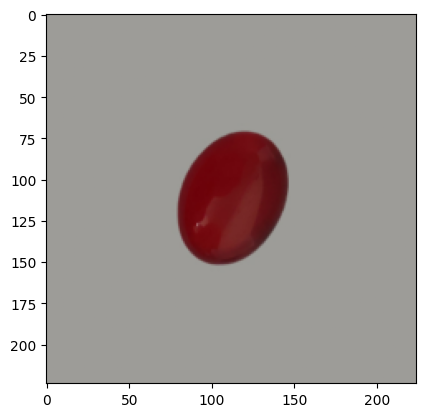


Sample Prediction 5:
Predicted Class: 2
Actual Class: 2


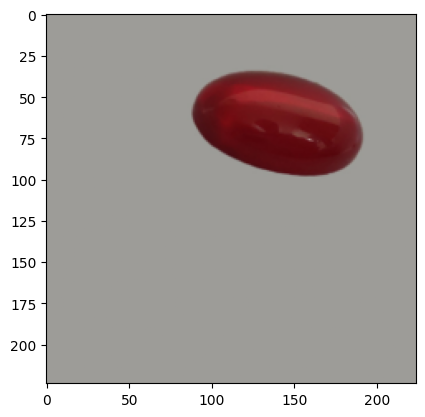

In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set the model to evaluation mode
model.eval()

# Lists to store predicted and actual labels
all_predicted_labels = []
all_actual_labels = []

# Lists to store sample images
sample_images = []

# Calculate loss for the entire test set
criterion = nn.CrossEntropyLoss()
test_loss = 0.0
num_batches = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        num_batches += 1

        # Get predicted labels
        predicted_labels = outputs.argmax(-1)

        # Append to the lists
        all_predicted_labels.extend(predicted_labels.cpu().numpy())
        all_actual_labels.extend(labels.cpu().numpy())

        # Append sample images
        sample_images.extend(inputs.cpu().numpy())

# Convert lists to NumPy arrays
all_predicted_labels = np.array(all_predicted_labels)
all_actual_labels = np.array(all_actual_labels)

# Calculate metrics
accuracy = accuracy_score(all_actual_labels, all_predicted_labels)
precision = precision_score(all_actual_labels, all_predicted_labels, average='weighted')
recall = recall_score(all_actual_labels, all_predicted_labels, average='weighted')
f1 = f1_score(all_actual_labels, all_predicted_labels, average='weighted')

print('Test Accuracy: {:.4f}'.format(accuracy))
print('Test Precision: {:.4f}'.format(precision))
print('Test Recall: {:.4f}'.format(recall))
print('Test F1 Score: {:.4f}'.format(f1))
print('Average Test Loss: {:.4f}'.format(test_loss / num_batches))

# Values for accuracy and loss every 5 epochs on test set
epoch_values_test = list(range(0, 101, 5))
accuracy_values_train = [0.5856, 0.7834, 0.7561, 0.8049, 0.8034, 0.7909, 0.8249, 0.8131, 0.8065, 0.8370, 0.7959, 0.8292, 0.8452, 0.8311, 0.8296, 0.8440, 0.8417, 0.8335, 0.8339, 0.8233, 0.8573]
accuracy_values_validation = [0.5293, 0.6827, 0.6500, 0.6840, 0.7127, 0.6720, 0.6780, 0.6873, 0.6893, 0.6073, 0.6947, 0.6807, 0.7027, 0.7000, 0.7047, 0.7020, 0.6833, 0.7187, 0.6560, 0.6720, 0.7147]

loss_values_train = [0.9977, 0.5099, 0.5937, 0.4775, 0.4691, 0.4940, 0.4302, 0.4435, 0.4614, 0.3987, 0.4647, 0.4138, 0.3690, 0.4043, 0.4198, 0.3995, 0.3923, 0.3945, 0.3992, 0.4234, 0.3401]
loss_values_validation = [0.8682, 0.8018, 0.7455, 0.7066, 0.7665, 0.8493, 0.7809, 0.8785, 0.7743, 0.8015, 0.6644, 0.8416, 0.8101, 0.7490, 0.7430, 0.7903, 0.7260, 0.7771, 0.8958, 0.8808, 0.7854]

# Plot accuracy and loss
epochs = range(1, 100 + 1)
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epoch_values_test, accuracy_values_train, label='Train Accuracy', marker='o')
plt.plot(epoch_values_test, accuracy_values_validation, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epoch_values_test, loss_values_train, label='Train Loss', marker='o', color='b')
plt.plot(epoch_values_test, loss_values_validation, label='Validation Loss', marker='o', color='g')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Display sample predictions with images after the first 5 predictions
SAMPLE_SIZE = 5
for i in range(min(SAMPLE_SIZE, len(all_actual_labels))):
    print('Sample Prediction {}:'.format(i + 1))
    print('Predicted Class:', all_predicted_labels[i])
    print('Actual Class:', all_actual_labels[i])

    # Display the image
    plt.imshow(np.transpose(sample_images[i], (1, 2, 0)))
    plt.show()
    print()


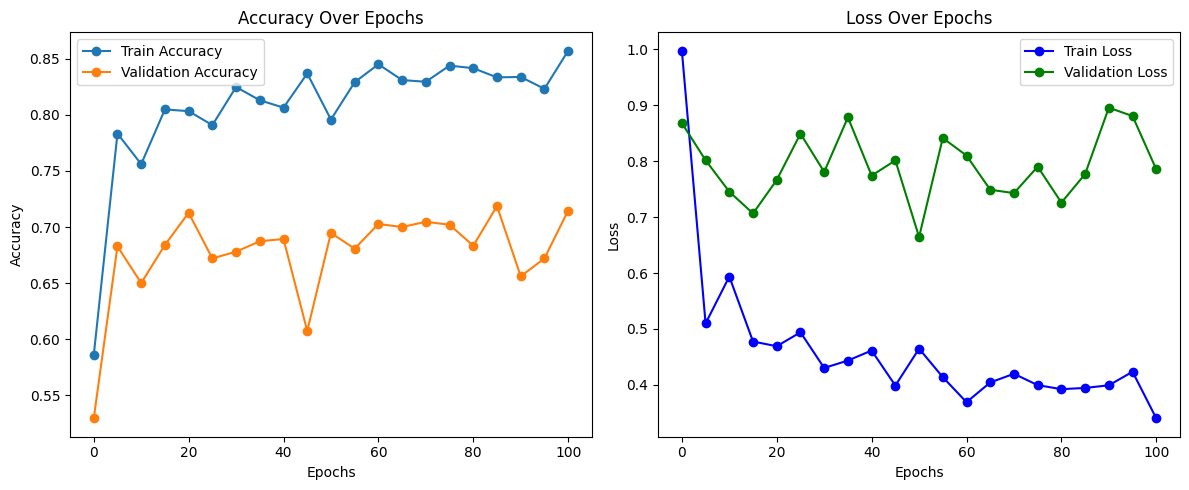

In [22]:

# Plot accuracy and loss
epochs = range(1, 100 + 1)
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epoch_values_test, accuracy_values_train, label='Train Accuracy', marker='o')
plt.plot(epoch_values_test, accuracy_values_validation, label='Validation Accuracy', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epoch_values_test, loss_values_train, label='Train Loss', marker='o', color='b')
plt.plot(epoch_values_test, loss_values_validation, label='Validation Loss', marker='o', color='g')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

